In [1]:
import numpy as np
import matplotlib.pyplot as plt
import minari
from d3rlpy.algos import IQLConfig, CQLConfig, BCConfig, TD3PlusBCConfig, AWACConfig
from d3rlpy.datasets import MDPDataset
from d3rlpy.constants import ActionSpace
from d3rlpy.metrics import EnvironmentEvaluator
import time

# Parameters of the experiments

In [2]:
# Loading Minari datasets for the tasks
pen_dataset = minari.load_dataset("D4RL/pen/expert-v2")
relocate_dataset = minari.load_dataset("D4RL/relocate/expert-v2")
hammer_dataset = minari.load_dataset("D4RL/hammer/expert-v2")
door_dataset = minari.load_dataset("D4RL/door/expert-v2")

# Total number of training updates
n_steps = 1_000 # 100_000

# Number of updates between two evaluations (epochs)
n_steps_per_epoch = 100 # 1000

# Number of episodes during the testing phase
N = 50

# Delay between one step of the episode and the next in simulation
delay = 0.01

# Loading and preparation of datasets

In [3]:
def prepare_d3_dataset(minari_dataset):
    # Lists to collect observations, actions, rewards, and terminals from all episodes
    observations = []
    actions = []
    rewards = []
    terminals = []

    # Iterate over episodes in the Minari dataset
    for episode in minari_dataset.iterate_episodes():
        # Extract sequences of data, removing the last observation
        obs = episode.observations[:-1]
        actions_ep = episode.actions
        rewards_ep = episode.rewards
        dones = np.array(episode.terminations) | np.array(episode.truncations)

        observations.append(obs)
        actions.append(actions_ep)
        rewards.append(rewards_ep)
        terminals.append(dones)

    # Merge all episodes into single arrays
    observations = np.concatenate(observations)
    actions = np.concatenate(actions)
    rewards = np.concatenate(rewards)
    terminals = np.concatenate(terminals)

    # Build the final dataset in d3rlpy's MDPDataset format
    d3_dataset = MDPDataset(
        observations=observations,
        actions=actions,
        rewards=rewards,
        terminals=terminals,
        action_space=ActionSpace.CONTINUOUS
    )

    return d3_dataset

In [4]:
# Conversion of Minari datasets into MDPDataset format for training
pen_d3_dataset = prepare_d3_dataset(pen_dataset)
relocate_d3_dataset = prepare_d3_dataset(relocate_dataset)
hammer_d3_dataset = prepare_d3_dataset(hammer_dataset)
door_d3_dataset = prepare_d3_dataset(door_dataset)

2025-05-18 11:34.18 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2025-05-18 11:34.18 [info     ] Action size has been automatically determined. action_size=24
2025-05-18 11:34.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(30,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2025-05-18 11:34.21 [info     ] Action size has been automatically determined. action_size=30
2025-05-18 11:34.24 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(26,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(46,)]) reward_signature=S

# Training Algorithm

In [5]:
def train_algorithm(config_class, dataset, env, filename):
    # Initialize the algorithm on CPU
    algo = config_class().create(device="cpu")

    # Build the neural networks based on the dataset
    algo.build_with_dataset(dataset)

    # Train the algorithm on the offline dataset and periodically evaluate online, saving the training history
    history = algo.fit(
        dataset=dataset,
        n_steps=n_steps,
        n_steps_per_epoch=n_steps_per_epoch,
        evaluators={"environment": EnvironmentEvaluator(env)}
    )

    algo.save(f'{filename}.d3')

    # Return the trained policy and the training history
    return algo, history

# Policy Training

### Pen

In [6]:
# Recover the environment for the task
pen_env = pen_dataset.recover_environment()

# Train all policies, also saving the training history
pen_iql, pen_iql_hist = train_algorithm(IQLConfig, pen_d3_dataset, pen_env, 'policies/pen_iql')
pen_cql, pen_cql_hist = train_algorithm(CQLConfig, pen_d3_dataset, pen_env, 'policies/pen_cql')
pen_bc, pen_bc_hist = train_algorithm(BCConfig, pen_d3_dataset, pen_env, 'policies/pen_bc')
pen_td3bc, pen_td3bc_hist = train_algorithm(TD3PlusBCConfig, pen_d3_dataset, pen_env, 'policies/pen_td3bc')
pen_awac, pen_awac_hist = train_algorithm(AWACConfig, pen_d3_dataset, pen_env, 'policies/pen_awac')

# Mapping of the training histories for the task
pen_histories = {
    'IQL': pen_iql_hist,
    'CQL': pen_cql_hist,
    'BC': pen_bc_hist,
    'TD3+BC': pen_td3bc_hist,
    'AWAC': pen_awac_hist
}

2025-05-18 11:34.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=24)
2025-05-18 11:34.29 [warning  ] Skip building models since they're already built.
2025-05-18 11:34.29 [info     ] Directory is created at d3rlpy_logs/IQL_20250518113429
2025-05-18 11:34.29 [info     ] Parameters                     params={'observation_shape': [45], 'action_size': 24, 'config': {'type': 'iql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0003, 'critic_learning_rate': 0.0003, 'actor_optim_factory': {'type': 'adam', 'params

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.30 [info     ] IQL_20250518113429: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0022010207176208496, 'time_algorithm_update': 0.006715052127838135, 'critic_loss': 2381.599006958008, 'q_loss': 2381.5979333496093, 'v_loss': 0.0010719578524003737, 'actor_loss': 32.912047929763794, 'time_step': 0.00895339012145996, 'environment': 536.7964524486869} step=100
2025-05-18 11:34.30 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.31 [info     ] IQL_20250518113429: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0017234563827514648, 'time_algorithm_update': 0.0071533632278442385, 'critic_loss': 674.0640469360352, 'q_loss': 674.0013098144532, 'v_loss': 0.06273715474177152, 'actor_loss': 14.191795387268066, 'time_step': 0.008909561634063722, 'environment': 700.0987899032443} step=200
2025-05-18 11:34.31 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.33 [info     ] IQL_20250518113429: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0016501927375793457, 'time_algorithm_update': 0.005932831764221191, 'critic_loss': 570.713896484375, 'q_loss': 570.1318270874024, 'v_loss': 0.5820706178247929, 'actor_loss': 54.19596683502197, 'time_step': 0.007615952491760254, 'environment': 1061.6833704152386} step=300
2025-05-18 11:34.33 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.34 [info     ] IQL_20250518113429: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0016422176361083984, 'time_algorithm_update': 0.005072531700134278, 'critic_loss': 537.2342712402344, 'q_loss': 535.2429104614258, 'v_loss': 1.9913606530427932, 'actor_loss': 93.28090454101563, 'time_step': 0.00674757719039917, 'environment': 577.6670629286498} step=400
2025-05-18 11:34.34 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.35 [info     ] IQL_20250518113429: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0016331696510314942, 'time_algorithm_update': 0.004988219738006592, 'critic_loss': 525.8696490478516, 'q_loss': 521.6926733398437, 'v_loss': 4.176975793838501, 'actor_loss': 95.34792686462403, 'time_step': 0.006654176712036133, 'environment': 987.8229721263427} step=500
2025-05-18 11:34.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.36 [info     ] IQL_20250518113429: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016399121284484863, 'time_algorithm_update': 0.004983623027801514, 'critic_loss': 570.116335144043, 'q_loss': 563.2217953491211, 'v_loss': 6.894536733627319, 'actor_loss': 95.5259767150879, 'time_step': 0.006656291484832763, 'environment': 1945.5728682058038} step=600
2025-05-18 11:34.36 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.37 [info     ] IQL_20250518113429: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0016329622268676759, 'time_algorithm_update': 0.00495464563369751, 'critic_loss': 612.2506463623047, 'q_loss': 603.4039144897461, 'v_loss': 8.846728558540343, 'actor_loss': 91.08500423431397, 'time_step': 0.006620473861694336, 'environment': 1497.2619936242731} step=700
2025-05-18 11:34.37 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.38 [info     ] IQL_20250518113429: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0016361832618713378, 'time_algorithm_update': 0.004963932037353516, 'critic_loss': 676.9806213378906, 'q_loss': 666.8458038330078, 'v_loss': 10.134817719459534, 'actor_loss': 82.53855556488037, 'time_step': 0.006632893085479736, 'environment': 2282.384241504902} step=800
2025-05-18 11:34.38 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.39 [info     ] IQL_20250518113429: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0016386127471923828, 'time_algorithm_update': 0.004995226860046387, 'critic_loss': 807.8608932495117, 'q_loss': 796.890285949707, 'v_loss': 10.970605554580688, 'actor_loss': 77.55829151153564, 'time_step': 0.006666679382324219, 'environment': 1146.1326359278812} step=900
2025-05-18 11:34.39 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.40 [info     ] IQL_20250518113429: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0017357707023620606, 'time_algorithm_update': 0.006146047115325928, 'critic_loss': 914.0972888183594, 'q_loss': 902.6160443115234, 'v_loss': 11.481246709823608, 'actor_loss': 76.3331351852417, 'time_step': 0.007934429645538331, 'environment': 1395.1668218349128} step=1000
2025-05-18 11:34.40 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113429/model_1000.d3
2025-05-18 11:34.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=24)
2025-05-18 11:34.40 [warning  ] Skip building models since they're already built.
2025-05-18 11:34.40 [info     ] Directory is created at d3rlpy_logs/C

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.43 [info     ] CQL_20250518113440: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.001781754493713379, 'time_algorithm_update': 0.028404250144958496, 'critic_loss': 2479.916888427734, 'conservative_loss': 77.28900695800782, 'alpha': 1.0047353327274322, 'actor_loss': -29.19856505393982, 'temp': 0.9949728339910507, 'temp_loss': 39.139950065612794, 'time_step': 0.03022812843322754, 'environment': 51.56037202368843} step=100
2025-05-18 11:34.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.47 [info     ] CQL_20250518113440: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.001781005859375, 'time_algorithm_update': 0.0292340612411499, 'critic_loss': 739.9545751953125, 'conservative_loss': 74.87898792266846, 'alpha': 1.0136616051197052, 'actor_loss': -52.18591995239258, 'temp': 0.9859418576955795, 'temp_loss': 30.51948308944702, 'time_step': 0.031057052612304688, 'environment': 575.6235136913623} step=200
2025-05-18 11:34.47 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.50 [info     ] CQL_20250518113440: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0017996716499328613, 'time_algorithm_update': 0.0283723783493042, 'critic_loss': 615.4386959838868, 'conservative_loss': 35.65719467163086, 'alpha': 1.0216134667396546, 'actor_loss': -60.478381881713865, 'temp': 0.9773830044269561, 'temp_loss': 30.912748794555664, 'time_step': 0.03021378517150879, 'environment': -1.0713466650868058} step=300
2025-05-18 11:34.50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.54 [info     ] CQL_20250518113440: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0017911076545715332, 'time_algorithm_update': 0.0281380295753479, 'critic_loss': 530.9116189575195, 'conservative_loss': 3.7782099157571793, 'alpha': 1.0248095393180847, 'actor_loss': -70.09589134216309, 'temp': 0.9683239305019379, 'temp_loss': 31.34889410018921, 'time_step': 0.029970059394836424, 'environment': 75.43522338463495} step=400
2025-05-18 11:34.54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:34.57 [info     ] CQL_20250518113440: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0017966246604919434, 'time_algorithm_update': 0.02841801881790161, 'critic_loss': 497.1221578979492, 'conservative_loss': -12.020712640285492, 'alpha': 1.0240232849121094, 'actor_loss': -82.41447853088378, 'temp': 0.9592686414718627, 'temp_loss': 30.024759902954102, 'time_step': 0.030256927013397217, 'environment': 10.729872534326313} step=500
2025-05-18 11:34.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.01 [info     ] CQL_20250518113440: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0018216991424560547, 'time_algorithm_update': 0.029363126754760743, 'critic_loss': 516.0398153686524, 'conservative_loss': -22.666426639556885, 'alpha': 1.0204839193820954, 'actor_loss': -96.90326141357421, 'temp': 0.9505928570032119, 'temp_loss': 28.198280601501466, 'time_step': 0.03122739791870117, 'environment': 182.90103679433702} step=600
2025-05-18 11:35.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.04 [info     ] CQL_20250518113440: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.001954669952392578, 'time_algorithm_update': 0.028724300861358642, 'critic_loss': 584.6869790649414, 'conservative_loss': -27.55111192703247, 'alpha': 1.0147373127937316, 'actor_loss': -111.53836143493652, 'temp': 0.9422299247980118, 'temp_loss': 27.187193355560304, 'time_step': 0.030724966526031496, 'environment': 1284.4649756927322} step=700
2025-05-18 11:35.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.08 [info     ] CQL_20250518113440: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0018083477020263672, 'time_algorithm_update': 0.02823296785354614, 'critic_loss': 701.8381228637695, 'conservative_loss': -32.78087648391724, 'alpha': 1.007559232711792, 'actor_loss': -126.64192176818848, 'temp': 0.9340368932485581, 'temp_loss': 26.143556632995605, 'time_step': 0.03008328914642334, 'environment': 552.0176615582379} step=800
2025-05-18 11:35.08 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.11 [info     ] CQL_20250518113440: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0017893528938293457, 'time_algorithm_update': 0.028324878215789794, 'critic_loss': 800.5459606933593, 'conservative_loss': -36.21907014846802, 'alpha': 0.9989891684055329, 'actor_loss': -142.1728835296631, 'temp': 0.9260186100006104, 'temp_loss': 25.38659757614136, 'time_step': 0.030155892372131347, 'environment': 45.11875955517583} step=900
2025-05-18 11:35.11 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.14 [info     ] CQL_20250518113440: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.001787405014038086, 'time_algorithm_update': 0.028777964115142822, 'critic_loss': 980.4092919921875, 'conservative_loss': -37.640467929840085, 'alpha': 0.9898655384778976, 'actor_loss': -158.02660507202148, 'temp': 0.9181167382001877, 'temp_loss': 24.570608139038086, 'time_step': 0.03060783624649048, 'environment': -0.870079921801987} step=1000
2025-05-18 11:35.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113440/model_1000.d3
2025-05-18 11:35.14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=24)
2025-05-18 11:35.14 [warning  ] Skip building models since they're already bu

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.15 [info     ] BC_20250518113514: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0007014679908752442, 'time_algorithm_update': 0.0007094097137451172, 'loss': 0.15179253205657006, 'time_step': 0.0014307355880737304, 'environment': 1383.8003818770514} step=100
2025-05-18 11:35.15 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.15 [info     ] BC_20250518113514: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0006897330284118652, 'time_algorithm_update': 0.0006973767280578614, 'loss': 0.10578585192561149, 'time_step': 0.0014035940170288087, 'environment': 2497.4956990013297} step=200
2025-05-18 11:35.15 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.16 [info     ] BC_20250518113514: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0006974983215332031, 'time_algorithm_update': 0.0007142972946166992, 'loss': 0.10323671452701091, 'time_step': 0.0014277935028076173, 'environment': 2299.6962781843145} step=300
2025-05-18 11:35.16 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.16 [info     ] BC_20250518113514: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0006366658210754394, 'time_algorithm_update': 0.0006095933914184571, 'loss': 0.10223076798021793, 'time_step': 0.0012578129768371581, 'environment': 1928.3851960527304} step=400
2025-05-18 11:35.16 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.17 [info     ] BC_20250518113514: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0006879615783691406, 'time_algorithm_update': 0.0006959676742553711, 'loss': 0.10052186265587806, 'time_step': 0.0013994336128234862, 'environment': 2078.100064892958} step=500
2025-05-18 11:35.17 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.17 [info     ] BC_20250518113514: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0006841254234313964, 'time_algorithm_update': 0.0007051491737365723, 'loss': 0.10063850976526738, 'time_step': 0.0014018464088439942, 'environment': 3142.7796141148765} step=600
2025-05-18 11:35.17 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.18 [info     ] BC_20250518113514: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0007082295417785645, 'time_algorithm_update': 0.0007288074493408203, 'loss': 0.1001861920952797, 'time_step': 0.0014518094062805176, 'environment': 3448.9970107934605} step=700
2025-05-18 11:35.18 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.18 [info     ] BC_20250518113514: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0006878447532653809, 'time_algorithm_update': 0.0006949615478515625, 'loss': 0.09996658772230148, 'time_step': 0.001399533748626709, 'environment': 3635.4059593021584} step=800
2025-05-18 11:35.18 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.19 [info     ] BC_20250518113514: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0006940531730651856, 'time_algorithm_update': 0.0006999611854553222, 'loss': 0.09978758543729782, 'time_step': 0.0014132952690124512, 'environment': 2536.49268173773} step=900
2025-05-18 11:35.19 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.19 [info     ] BC_20250518113514: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0006784915924072266, 'time_algorithm_update': 0.0006836533546447753, 'loss': 0.09989018991589546, 'time_step': 0.0013794350624084474, 'environment': 2122.3145331699807} step=1000
2025-05-18 11:35.19 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113514/model_1000.d3
2025-05-18 11:35.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=24)
2025-05-18 11:35.19 [warning  ] Skip building models since they're already built.
2025-05-18 11:35.19 [info     ] Directory is created at d3rlpy_logs/TD3PlusBC_20250518113519
2025-05-18 11:35.19 [info     ] Parameters                     params={'

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.20 [info     ] TD3PlusBC_20250518113519: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0016223740577697753, 'time_algorithm_update': 0.003943042755126953, 'critic_loss': 2452.9254693603516, 'actor_loss': -1.9281653594970702, 'bc_loss': 0.4770185953378677, 'time_step': 0.005597236156463623, 'environment': 137.694551049783} step=100
2025-05-18 11:35.20 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.21 [info     ] TD3PlusBC_20250518113519: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.001647942066192627, 'time_algorithm_update': 0.0046242809295654295, 'critic_loss': 665.3265075683594, 'actor_loss': -1.793461389541626, 'bc_loss': 0.7065386033058166, 'time_step': 0.0063029837608337405, 'environment': 7.403544366746798} step=200
2025-05-18 11:35.21 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.22 [info     ] TD3PlusBC_20250518113519: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.001629343032836914, 'time_algorithm_update': 0.004383931159973145, 'critic_loss': 547.8308670043946, 'actor_loss': -1.8020635724067688, 'bc_loss': 0.697936419248581, 'time_step': 0.006043691635131836, 'environment': -16.56725777334379} step=300
2025-05-18 11:35.22 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.23 [info     ] TD3PlusBC_20250518113519: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0016777443885803223, 'time_algorithm_update': 0.0041617250442504885, 'critic_loss': 494.31963714599607, 'actor_loss': -1.869063014984131, 'bc_loss': 0.630937043428421, 'time_step': 0.005873460769653321, 'environment': 15.596024242878224} step=400
2025-05-18 11:35.23 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.24 [info     ] TD3PlusBC_20250518113519: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0016191625595092774, 'time_algorithm_update': 0.0038707661628723145, 'critic_loss': 458.16974365234375, 'actor_loss': -1.9091572213172912, 'bc_loss': 0.5908337581157684, 'time_step': 0.0055214762687683105, 'environment': -2.1579736154345377} step=500
2025-05-18 11:35.24 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.25 [info     ] TD3PlusBC_20250518113519: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016202783584594726, 'time_algorithm_update': 0.0037987375259399413, 'critic_loss': 445.66060119628906, 'actor_loss': -2.016256101131439, 'bc_loss': 0.4837318551540375, 'time_step': 0.00545027494430542, 'environment': 32.06624120242384} step=600
2025-05-18 11:35.25 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.26 [info     ] TD3PlusBC_20250518113519: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.001625974178314209, 'time_algorithm_update': 0.003804745674133301, 'critic_loss': 439.05357421875, 'actor_loss': -2.138242177963257, 'bc_loss': 0.3617578125, 'time_step': 0.005462183952331543, 'environment': -2.073573440646631} step=700
2025-05-18 11:35.26 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.27 [info     ] TD3PlusBC_20250518113519: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.001616528034210205, 'time_algorithm_update': 0.0038403034210205077, 'critic_loss': 451.21620697021484, 'actor_loss': -2.1960083723068236, 'bc_loss': 0.30396885514259336, 'time_step': 0.005487790107727051, 'environment': 14.47395596448425} step=800
2025-05-18 11:35.27 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.28 [info     ] TD3PlusBC_20250518113519: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0016156935691833496, 'time_algorithm_update': 0.003857409954071045, 'critic_loss': 466.06749237060546, 'actor_loss': -2.2191053152084352, 'bc_loss': 0.280865523815155, 'time_step': 0.005504360198974609, 'environment': 10.551185963404178} step=900
2025-05-18 11:35.28 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.29 [info     ] TD3PlusBC_20250518113519: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.001626598834991455, 'time_algorithm_update': 0.003901829719543457, 'critic_loss': 502.1408941650391, 'actor_loss': -2.2418664026260378, 'bc_loss': 0.2576263841986656, 'time_step': 0.005559618473052978, 'environment': 21.411676632830297} step=1000
2025-05-18 11:35.29 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113519/model_1000.d3
2025-05-18 11:35.29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=24)
2025-05-18 11:35.29 [warning  ] Skip building models since they're already built.
2025-05-18 11:35.29 [info     ] Directory is created at d3rlpy_logs/AWAC_2025051811

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.31 [info     ] AWAC_20250518113529: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.006338183879852295, 'time_algorithm_update': 0.010812048912048339, 'critic_loss': 1479.2217297363281, 'actor_loss': 824005.9875, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017187068462371825, 'environment': -1.1116178890737793} step=100
2025-05-18 11:35.31 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.33 [info     ] AWAC_20250518113529: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.006375021934509277, 'time_algorithm_update': 0.01136040449142456, 'critic_loss': 660.3216430664063, 'actor_loss': 395916.9790625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01777326822280884, 'environment': 25.786558964949233} step=200
2025-05-18 11:35.33 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.35 [info     ] AWAC_20250518113529: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.006381146907806397, 'time_algorithm_update': 0.010878674983978272, 'critic_loss': 542.678489074707, 'actor_loss': 381580.926875, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017296228408813476, 'environment': 218.61449726533706} step=300
2025-05-18 11:35.35 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.38 [info     ] AWAC_20250518113529: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.009272747039794922, 'time_algorithm_update': 0.010554218292236328, 'critic_loss': 471.5026852416992, 'actor_loss': 465648.90859375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.019863576889038087, 'environment': 46.406454837837096} step=400
2025-05-18 11:35.38 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.40 [info     ] AWAC_20250518113529: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.006420433521270752, 'time_algorithm_update': 0.010517055988311768, 'critic_loss': 439.63514587402346, 'actor_loss': 455624.98703125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016974728107452392, 'environment': 275.08404085188533} step=500
2025-05-18 11:35.40 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.42 [info     ] AWAC_20250518113529: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.006405513286590576, 'time_algorithm_update': 0.010436463356018066, 'critic_loss': 416.73783599853516, 'actor_loss': 398770.8228125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016878097057342528, 'environment': 104.99309835719313} step=600
2025-05-18 11:35.42 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.44 [info     ] AWAC_20250518113529: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.006405847072601318, 'time_algorithm_update': 0.010438144207000732, 'critic_loss': 411.8682046508789, 'actor_loss': 400175.72140625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016880440711975097, 'environment': 514.0445769086949} step=700
2025-05-18 11:35.44 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.46 [info     ] AWAC_20250518113529: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.006410419940948486, 'time_algorithm_update': 0.010427684783935546, 'critic_loss': 394.7635009765625, 'actor_loss': 362101.4540625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016874353885650634, 'environment': 564.0221470969522} step=800
2025-05-18 11:35.46 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.48 [info     ] AWAC_20250518113529: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.00641068696975708, 'time_algorithm_update': 0.010451271533966064, 'critic_loss': 397.82143341064454, 'actor_loss': 312570.05484375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016898338794708253, 'environment': 28.217823486308276} step=900
2025-05-18 11:35.48 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.50 [info     ] AWAC_20250518113529: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.006419994831085205, 'time_algorithm_update': 0.010432231426239013, 'critic_loss': 407.0750213623047, 'actor_loss': 308566.540625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01688838243484497, 'environment': 185.33329632576442} step=1000
2025-05-18 11:35.50 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113529/model_1000.d3


### Relocate

In [7]:
relocate_env = relocate_dataset.recover_environment()
relocate_iql, relocate_iql_hist = train_algorithm(IQLConfig, relocate_d3_dataset, relocate_env, 'policies/relocate_iql')
relocate_cql, relocate_cql_hist = train_algorithm(CQLConfig, relocate_d3_dataset, relocate_env, 'policies/relocate_cql')
relocate_bc, relocate_bc_hist = train_algorithm(BCConfig, relocate_d3_dataset, relocate_env, 'policies/relocate_bc')
relocate_td3bc, relocate_td3bc_hist = train_algorithm(TD3PlusBCConfig, relocate_d3_dataset, relocate_env, 'policies/relocate_td3bc')
relocate_awac, relocate_awac_hist = train_algorithm(AWACConfig, relocate_d3_dataset, relocate_env, 'policies/relocate_awac')
relocate_histories = {
    'IQL': relocate_iql_hist,
    'CQL': relocate_cql_hist,
    'BC': relocate_bc_hist,
    'TD3+BC': relocate_td3bc_hist,
    'AWAC': relocate_awac_hist
}

2025-05-18 11:35.50 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(30,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=30)
2025-05-18 11:35.50 [warning  ] Skip building models since they're already built.
2025-05-18 11:35.50 [info     ] Directory is created at d3rlpy_logs/IQL_20250518113550
2025-05-18 11:35.50 [info     ] Parameters                     params={'observation_shape': [39], 'action_size': 30, 'config': {'type': 'iql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0003, 'critic_learning_rate': 0.0003, 'actor_optim_factory': {'type': 'adam', 'params

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.52 [info     ] IQL_20250518113550: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.002468869686126709, 'time_algorithm_update': 0.005020029544830322, 'critic_loss': 693.8004641723633, 'q_loss': 693.7997561645508, 'v_loss': 0.000706713645849959, 'actor_loss': 10.011173787489533, 'time_step': 0.007523219585418701, 'environment': 5.87657314220303} step=100
2025-05-18 11:35.52 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.53 [info     ] IQL_20250518113550: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.001787106990814209, 'time_algorithm_update': 0.005319018363952637, 'critic_loss': 133.72707901000976, 'q_loss': 133.69408660888672, 'v_loss': 0.03299279663944617, 'actor_loss': -2.4906241995096208, 'time_step': 0.007139096260070801, 'environment': 7.657724932332572} step=200
2025-05-18 11:35.53 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.54 [info     ] IQL_20250518113550: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0016869306564331055, 'time_algorithm_update': 0.00510991096496582, 'critic_loss': 99.50299285888671, 'q_loss': 99.28565753936768, 'v_loss': 0.2173353236168623, 'actor_loss': -14.506213405132293, 'time_step': 0.006829338073730469, 'environment': 7.985174274352424} step=300
2025-05-18 11:35.54 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.55 [info     ] IQL_20250518113550: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.001658475399017334, 'time_algorithm_update': 0.005455079078674316, 'critic_loss': 88.07238414764404, 'q_loss': 87.48471084594726, 'v_loss': 0.5876732301712037, 'actor_loss': -51.052750492095946, 'time_step': 0.007146124839782715, 'environment': 7.230970492333796} step=400
2025-05-18 11:35.55 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.56 [info     ] IQL_20250518113550: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0016829633712768554, 'time_algorithm_update': 0.005183112621307373, 'critic_loss': 84.06102153778076, 'q_loss': 83.04608116149902, 'v_loss': 1.0149410307407378, 'actor_loss': -90.55640563964843, 'time_step': 0.00689927339553833, 'environment': 10.845570582839828} step=500
2025-05-18 11:35.56 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.58 [info     ] IQL_20250518113550: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016450810432434083, 'time_algorithm_update': 0.004847209453582763, 'critic_loss': 87.58552829742432, 'q_loss': 86.21935859680175, 'v_loss': 1.3661696457862853, 'actor_loss': -121.70225952148438, 'time_step': 0.00652498722076416, 'environment': 7.254233349175804} step=600
2025-05-18 11:35.58 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:35.59 [info     ] IQL_20250518113550: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0016387248039245606, 'time_algorithm_update': 0.004837379455566406, 'critic_loss': 92.46827659606933, 'q_loss': 90.97581176757812, 'v_loss': 1.4924651277065277, 'actor_loss': -136.2061996459961, 'time_step': 0.006508145332336426, 'environment': 177.2625783658639} step=700
2025-05-18 11:35.59 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.00 [info     ] IQL_20250518113550: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0016353535652160645, 'time_algorithm_update': 0.004877033233642578, 'critic_loss': 103.47829746246337, 'q_loss': 101.96123588562011, 'v_loss': 1.5170617890357971, 'actor_loss': -145.319479598999, 'time_step': 0.0065449666976928715, 'environment': 10.121672794096266} step=800
2025-05-18 11:36.00 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.01 [info     ] IQL_20250518113550: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0016335558891296387, 'time_algorithm_update': 0.004899799823760986, 'critic_loss': 130.99740741729735, 'q_loss': 129.40698890686036, 'v_loss': 1.5904183101654052, 'actor_loss': -152.21822326660157, 'time_step': 0.006566281318664551, 'environment': 783.2512698492783} step=900
2025-05-18 11:36.01 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.03 [info     ] IQL_20250518113550: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0016306018829345703, 'time_algorithm_update': 0.004889593124389648, 'critic_loss': 144.06506839752197, 'q_loss': 142.3884001159668, 'v_loss': 1.6766684198379516, 'actor_loss': -159.42055839538574, 'time_step': 0.006553108692169189, 'environment': 175.69946329911326} step=1000
2025-05-18 11:36.03 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113550/model_1000.d3
2025-05-18 11:36.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(30,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=30)
2025-05-18 11:36.03 [warning  ] Skip building models since they're already built.
2025-05-18 11:36.03 [info     ] Directory is created at d3rlpy_lo

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.06 [info     ] CQL_20250518113603: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.001850283145904541, 'time_algorithm_update': 0.028236734867095947, 'critic_loss': 846.6153294372558, 'conservative_loss': 102.76020252227784, 'alpha': 1.0047189486026764, 'actor_loss': -24.97874267578125, 'temp': 0.994972625374794, 'temp_loss': 49.114091567993164, 'time_step': 0.03012953996658325, 'environment': 13.329946843830268} step=100
2025-05-18 11:36.06 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.10 [info     ] CQL_20250518113603: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0018516039848327636, 'time_algorithm_update': 0.028618011474609375, 'critic_loss': 147.54631057739257, 'conservative_loss': 18.94122273385525, 'alpha': 1.0102691018581391, 'actor_loss': -33.39873695373535, 'temp': 0.9857231509685517, 'temp_loss': 40.833783340454104, 'time_step': 0.030512168407440185, 'environment': 5.415665094925323} step=200
2025-05-18 11:36.10 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.13 [info     ] CQL_20250518113603: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.001893317699432373, 'time_algorithm_update': 0.02860247850418091, 'critic_loss': 39.65441879272461, 'conservative_loss': -47.75829790115356, 'alpha': 1.0087927186489105, 'actor_loss': -33.75074413299561, 'temp': 0.9770655483007431, 'temp_loss': 37.695252113342285, 'time_step': 0.03053924798965454, 'environment': 4.483611161900178} step=300
2025-05-18 11:36.13 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.17 [info     ] CQL_20250518113603: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0018709754943847655, 'time_algorithm_update': 0.027817037105560303, 'critic_loss': -11.653910064697266, 'conservative_loss': -97.07793251037597, 'alpha': 0.9987174141407013, 'actor_loss': -38.05887348175049, 'temp': 0.9688484632968902, 'temp_loss': 33.226317729949955, 'time_step': 0.02972985029220581, 'environment': 5.741623391286018} step=400
2025-05-18 11:36.17 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.20 [info     ] CQL_20250518113603: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0018336844444274902, 'time_algorithm_update': 0.027824175357818604, 'critic_loss': -34.76176330566406, 'conservative_loss': -123.77323936462402, 'alpha': 0.9848674982786179, 'actor_loss': -46.134478378295896, 'temp': 0.9612566101551056, 'temp_loss': 29.125451068878174, 'time_step': 0.029700114727020263, 'environment': 5.1579517792981715} step=500
2025-05-18 11:36.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.24 [info     ] CQL_20250518113603: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.001824815273284912, 'time_algorithm_update': 0.02891974687576294, 'critic_loss': -35.2848038482666, 'conservative_loss': -137.24746711730958, 'alpha': 0.9709528779983521, 'actor_loss': -56.74301078796387, 'temp': 0.9541776806116105, 'temp_loss': 26.199782218933105, 'time_step': 0.030789124965667724, 'environment': 4.704697949044023} step=600
2025-05-18 11:36.24 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.28 [info     ] CQL_20250518113603: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0018837404251098632, 'time_algorithm_update': 0.028627457618713378, 'critic_loss': -15.46285400390625, 'conservative_loss': -143.4007080078125, 'alpha': 0.9577596199512481, 'actor_loss': -68.33261154174805, 'temp': 0.9473934876918793, 'temp_loss': 24.388513736724853, 'time_step': 0.030554752349853515, 'environment': 4.728509080168419} step=700
2025-05-18 11:36.28 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.31 [info     ] CQL_20250518113603: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.001816411018371582, 'time_algorithm_update': 0.02794494867324829, 'critic_loss': 6.907085876464844, 'conservative_loss': -147.78493560791014, 'alpha': 0.9453567957878113, 'actor_loss': -80.97249458312989, 'temp': 0.9407189857959747, 'temp_loss': 23.13271478652954, 'time_step': 0.02980438470840454, 'environment': 5.154570557436984} step=800
2025-05-18 11:36.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.35 [info     ] CQL_20250518113603: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0018249917030334472, 'time_algorithm_update': 0.028031663894653322, 'critic_loss': 35.19589401245117, 'conservative_loss': -149.27162368774415, 'alpha': 0.93359643638134, 'actor_loss': -94.12719352722168, 'temp': 0.9340974259376525, 'temp_loss': 22.058065872192383, 'time_step': 0.02989912748336792, 'environment': 5.448456584363722} step=900
2025-05-18 11:36.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.38 [info     ] CQL_20250518113603: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0018141818046569823, 'time_algorithm_update': 0.02886718511581421, 'critic_loss': 62.89590118408203, 'conservative_loss': -150.0932504272461, 'alpha': 0.9223744744062423, 'actor_loss': -107.45515007019043, 'temp': 0.9275196093320847, 'temp_loss': 21.431965236663817, 'time_step': 0.030724215507507324, 'environment': 4.837550167901642} step=1000
2025-05-18 11:36.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113603/model_1000.d3
2025-05-18 11:36.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(30,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=30)
2025-05-18 11:36.38 [warning  ] Skip building models since they're already bui

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.39 [info     ] BC_20250518113638: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0006922578811645508, 'time_algorithm_update': 0.000891273021697998, 'loss': 0.07174475505948066, 'time_step': 0.001612403392791748, 'environment': 7.216831272621124} step=100
2025-05-18 11:36.39 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.40 [info     ] BC_20250518113638: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0006888937950134277, 'time_algorithm_update': 0.0009358906745910644, 'loss': 0.050418108552694324, 'time_step': 0.0016483068466186523, 'environment': 129.3006188682072} step=200
2025-05-18 11:36.40 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.41 [info     ] BC_20250518113638: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0009565401077270508, 'time_algorithm_update': 0.0019557523727416993, 'loss': 0.0490312872081995, 'time_step': 0.002944138050079346, 'environment': 608.5274097985454} step=300
2025-05-18 11:36.41 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.42 [info     ] BC_20250518113638: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0008551287651062012, 'time_algorithm_update': 0.0007861804962158203, 'loss': 0.048369195610284806, 'time_step': 0.0016604089736938477, 'environment': 617.6068659959012} step=400
2025-05-18 11:36.42 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.43 [info     ] BC_20250518113638: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.000835883617401123, 'time_algorithm_update': 0.0007499003410339355, 'loss': 0.04773380324244499, 'time_step': 0.0016077089309692383, 'environment': 1318.7430491791633} step=500
2025-05-18 11:36.43 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.44 [info     ] BC_20250518113638: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0007034897804260254, 'time_algorithm_update': 0.0007264471054077149, 'loss': 0.04796523481607437, 'time_step': 0.0014529824256896973, 'environment': 1157.6710299990389} step=600
2025-05-18 11:36.44 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.45 [info     ] BC_20250518113638: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0006752634048461915, 'time_algorithm_update': 0.0007149624824523926, 'loss': 0.047715463228523734, 'time_step': 0.0014070820808410643, 'environment': 3034.4502728970806} step=700
2025-05-18 11:36.45 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.46 [info     ] BC_20250518113638: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0006700038909912109, 'time_algorithm_update': 0.0007242536544799804, 'loss': 0.04727649979293346, 'time_step': 0.0014125871658325195, 'environment': 2202.566532947273} step=800
2025-05-18 11:36.46 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.47 [info     ] BC_20250518113638: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0006415486335754394, 'time_algorithm_update': 0.0006991386413574219, 'loss': 0.04717326130717993, 'time_step': 0.0013567590713500976, 'environment': 2844.1866401721636} step=900
2025-05-18 11:36.47 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.48 [info     ] BC_20250518113638: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0006557893753051758, 'time_algorithm_update': 0.0007313299179077149, 'loss': 0.047294383384287354, 'time_step': 0.0014081668853759765, 'environment': 2296.9492979952465} step=1000
2025-05-18 11:36.48 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113638/model_1000.d3
2025-05-18 11:36.48 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(30,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=30)
2025-05-18 11:36.48 [warning  ] Skip building models since they're already built.
2025-05-18 11:36.48 [info     ] Directory is created at d3rlpy_logs/TD3PlusBC_20250518113648
2025-05-18 11:36.48 [info     ] Parameters                     params={

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.49 [info     ] TD3PlusBC_20250518113648: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.001743316650390625, 'time_algorithm_update': 0.0038873648643493654, 'critic_loss': 687.3801139068604, 'actor_loss': -2.2743321371078493, 'bc_loss': 0.2252158635854721, 'time_step': 0.0056631040573120114, 'environment': 20.899815775847273} step=100
2025-05-18 11:36.49 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.50 [info     ] TD3PlusBC_20250518113648: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0016801166534423828, 'time_algorithm_update': 0.004369080066680908, 'critic_loss': 131.10711135864258, 'actor_loss': -2.030393826961517, 'bc_loss': 0.46960617780685426, 'time_step': 0.006080565452575684, 'environment': 18.435674703770438} step=200
2025-05-18 11:36.50 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.51 [info     ] TD3PlusBC_20250518113648: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0016244959831237793, 'time_algorithm_update': 0.0037151551246643066, 'critic_loss': 91.45868103027344, 'actor_loss': -1.9950785875320434, 'bc_loss': 0.5049214124679565, 'time_step': 0.005370719432830811, 'environment': 8.36169852189952} step=300
2025-05-18 11:36.51 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.53 [info     ] TD3PlusBC_20250518113648: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0016228222846984863, 'time_algorithm_update': 0.003593778610229492, 'critic_loss': 73.15572532653809, 'actor_loss': -1.9860795855522155, 'bc_loss': 0.5139204245805741, 'time_step': 0.005246915817260742, 'environment': 8.292773178393052} step=400
2025-05-18 11:36.53 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.54 [info     ] TD3PlusBC_20250518113648: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0016251659393310546, 'time_algorithm_update': 0.003504164218902588, 'critic_loss': 68.00281635284423, 'actor_loss': -2.041415820121765, 'bc_loss': 0.458477703332901, 'time_step': 0.005159735679626465, 'environment': 8.258658600861306} step=500
2025-05-18 11:36.54 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.55 [info     ] TD3PlusBC_20250518113648: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016158437728881836, 'time_algorithm_update': 0.0035691428184509277, 'critic_loss': 66.05196659088135, 'actor_loss': -2.1084888648986815, 'bc_loss': 0.3915068852901459, 'time_step': 0.005215580463409424, 'environment': 13.040578236857243} step=600
2025-05-18 11:36.55 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.56 [info     ] TD3PlusBC_20250518113648: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0016161751747131347, 'time_algorithm_update': 0.0035467815399169923, 'critic_loss': 69.66875469207764, 'actor_loss': -2.1750862979888916, 'bc_loss': 0.3249136871099472, 'time_step': 0.005192708969116211, 'environment': 25.39205118737486} step=700
2025-05-18 11:36.56 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.57 [info     ] TD3PlusBC_20250518113648: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0016059136390686034, 'time_algorithm_update': 0.0035738348960876465, 'critic_loss': 74.47972234725952, 'actor_loss': -2.198437900543213, 'bc_loss': 0.30156207978725436, 'time_step': 0.0052106094360351565, 'environment': 11.565408190911016} step=800
2025-05-18 11:36.57 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.58 [info     ] TD3PlusBC_20250518113648: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.001608574390411377, 'time_algorithm_update': 0.0035584259033203127, 'critic_loss': 81.69596923828125, 'actor_loss': -2.211394200325012, 'bc_loss': 0.28860580146312714, 'time_step': 0.00519705057144165, 'environment': 13.08374410659932} step=900
2025-05-18 11:36.58 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:36.59 [info     ] TD3PlusBC_20250518113648: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0016281867027282714, 'time_algorithm_update': 0.0035812735557556154, 'critic_loss': 89.26720573425293, 'actor_loss': -2.2301570129394532, 'bc_loss': 0.26984298348426816, 'time_step': 0.005239906311035156, 'environment': 11.881442659896182} step=1000
2025-05-18 11:36.59 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113648/model_1000.d3
2025-05-18 11:36.59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(30,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=30)
2025-05-18 11:36.59 [warning  ] Skip building models since they're already built.
2025-05-18 11:36.59 [info     ] Directory is created at d3rlpy_logs/AWAC_2025051

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.02 [info     ] AWAC_20250518113659: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.006796741485595703, 'time_algorithm_update': 0.011081550121307373, 'critic_loss': 1196.1217324829101, 'actor_loss': 504274.3975, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01791590690612793, 'environment': 6.144617008164104} step=100
2025-05-18 11:37.02 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.04 [info     ] AWAC_20250518113659: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.006461517810821533, 'time_algorithm_update': 0.011186304092407227, 'critic_loss': 272.1867985534668, 'actor_loss': 218457.979375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017684922218322754, 'environment': 7.612950937223194} step=200
2025-05-18 11:37.04 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.06 [info     ] AWAC_20250518113659: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.006447668075561523, 'time_algorithm_update': 0.010473787784576416, 'critic_loss': 212.1670930480957, 'actor_loss': 196590.371875, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016958181858062745, 'environment': 8.460210931102434} step=300
2025-05-18 11:37.06 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.08 [info     ] AWAC_20250518113659: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0064540600776672365, 'time_algorithm_update': 0.010465822219848632, 'critic_loss': 194.56658378601074, 'actor_loss': 184965.174375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016956334114074708, 'environment': 8.988240092865768} step=400
2025-05-18 11:37.08 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.11 [info     ] AWAC_20250518113659: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.006467249393463135, 'time_algorithm_update': 0.01040346622467041, 'critic_loss': 188.71997077941896, 'actor_loss': 173663.69, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016905460357666015, 'environment': 7.9043317030629066} step=500
2025-05-18 11:37.11 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.13 [info     ] AWAC_20250518113659: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.006501433849334717, 'time_algorithm_update': 0.010511105060577392, 'critic_loss': 188.56453903198243, 'actor_loss': 160835.054140625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017049000263214112, 'environment': 9.131514397873238} step=600
2025-05-18 11:37.13 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.15 [info     ] AWAC_20250518113659: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.00650386095046997, 'time_algorithm_update': 0.01048091173171997, 'critic_loss': 196.09713653564452, 'actor_loss': 145690.288828125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01702116012573242, 'environment': 8.411297341712231} step=700
2025-05-18 11:37.15 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.17 [info     ] AWAC_20250518113659: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.006484549045562744, 'time_algorithm_update': 0.010358326435089112, 'critic_loss': 198.14004219055175, 'actor_loss': 130941.771015625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01687833309173584, 'environment': 8.73882110261712} step=800
2025-05-18 11:37.17 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.20 [info     ] AWAC_20250518113659: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0064975953102111815, 'time_algorithm_update': 0.010507218837738037, 'critic_loss': 201.8819560241699, 'actor_loss': 122438.919140625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017041280269622802, 'environment': 7.961792811409223} step=900
2025-05-18 11:37.20 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.22 [info     ] AWAC_20250518113659: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.006511807441711426, 'time_algorithm_update': 0.01043175458908081, 'critic_loss': 214.12253295898438, 'actor_loss': 110878.546796875, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016979503631591796, 'environment': 9.21581393977623} step=1000
2025-05-18 11:37.22 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113659/model_1000.d3


### Hammer

In [8]:
hammer_env = hammer_dataset.recover_environment()
hammer_iql, hammer_iql_hist = train_algorithm(IQLConfig, hammer_d3_dataset, hammer_env, 'policies/hammer_iql')
hammer_cql, hammer_cql_hist = train_algorithm(CQLConfig, hammer_d3_dataset, hammer_env, 'policies/hammer_cql')
hammer_bc, hammer_bc_hist = train_algorithm(BCConfig, hammer_d3_dataset, hammer_env, 'policies/hammer_bc')
hammer_td3bc, hammer_td3bc_hist = train_algorithm(TD3PlusBCConfig, hammer_d3_dataset, hammer_env, 'policies/hammer_td3bc')
hammer_awac, hammer_awac_hist = train_algorithm(AWACConfig, hammer_d3_dataset, hammer_env, 'policies/hammer_awac')
hammer_histories = {
    'IQL': hammer_iql_hist,
    'CQL': hammer_cql_hist,
    'BC': hammer_bc_hist,
    'TD3+BC': hammer_td3bc_hist,
    'AWAC': hammer_awac_hist
}

2025-05-18 11:37.22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(46,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(26,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=26)
2025-05-18 11:37.22 [warning  ] Skip building models since they're already built.
2025-05-18 11:37.22 [info     ] Directory is created at d3rlpy_logs/IQL_20250518113722
2025-05-18 11:37.22 [info     ] Parameters                     params={'observation_shape': [46], 'action_size': 26, 'config': {'type': 'iql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0003, 'critic_learning_rate': 0.0003, 'actor_optim_factory': {'type': 'adam', 'params

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.23 [info     ] IQL_20250518113722: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0027071022987365722, 'time_algorithm_update': 0.0051375007629394535, 'critic_loss': 8661.902521972655, 'q_loss': 8661.9017578125, 'v_loss': 0.0008957057513180189, 'actor_loss': 16.59171981573105, 'time_step': 0.00788233757019043, 'environment': -232.86855954093045} step=100
2025-05-18 11:37.23 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.25 [info     ] IQL_20250518113722: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.001949009895324707, 'time_algorithm_update': 0.006118760108947754, 'critic_loss': 2311.19345703125, 'q_loss': 2311.095548095703, 'v_loss': 0.09790218552574516, 'actor_loss': 2.4885015246272086, 'time_step': 0.008104126453399658, 'environment': -233.39519312190495} step=200
2025-05-18 11:37.25 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.26 [info     ] IQL_20250518113722: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0017202115058898926, 'time_algorithm_update': 0.004924759864807129, 'critic_loss': 1547.0789904785156, 'q_loss': 1545.7403405761718, 'v_loss': 1.3386469447612763, 'actor_loss': 0.04658251196146011, 'time_step': 0.0066797399520874025, 'environment': -236.41029723737347} step=300
2025-05-18 11:37.26 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.28 [info     ] IQL_20250518113722: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.001670997142791748, 'time_algorithm_update': 0.004961690902709961, 'critic_loss': 1473.400313720703, 'q_loss': 1467.1150744628906, 'v_loss': 6.285242500305176, 'actor_loss': -20.980704569816588, 'time_step': 0.006667146682739258, 'environment': -237.7033229299665} step=400
2025-05-18 11:37.28 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.29 [info     ] IQL_20250518113722: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.001653308868408203, 'time_algorithm_update': 0.0049476313591003416, 'critic_loss': 1470.8259423828124, 'q_loss': 1454.9917785644532, 'v_loss': 15.834164638519287, 'actor_loss': -38.623745613098144, 'time_step': 0.006635293960571289, 'environment': 13730.470906850078} step=500
2025-05-18 11:37.29 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.31 [info     ] IQL_20250518113722: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016669988632202148, 'time_algorithm_update': 0.005067594051361084, 'critic_loss': 1525.8177130126953, 'q_loss': 1496.2580712890624, 'v_loss': 29.559639663696288, 'actor_loss': -52.79258600234985, 'time_step': 0.006767716407775879, 'environment': 11270.535891858934} step=600
2025-05-18 11:37.31 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.32 [info     ] IQL_20250518113722: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0016490340232849122, 'time_algorithm_update': 0.0049697160720825195, 'critic_loss': 1685.5123681640625, 'q_loss': 1643.8306018066405, 'v_loss': 41.68177032470703, 'actor_loss': -59.90659763336182, 'time_step': 0.006653454303741455, 'environment': -236.42785243876347} step=700
2025-05-18 11:37.32 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.34 [info     ] IQL_20250518113722: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.001656486988067627, 'time_algorithm_update': 0.0049442720413208005, 'critic_loss': 1828.1471655273438, 'q_loss': 1774.0395239257812, 'v_loss': 54.10764259338379, 'actor_loss': -59.00245132446289, 'time_step': 0.006634664535522461, 'environment': -236.6077971149813} step=800
2025-05-18 11:37.34 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.35 [info     ] IQL_20250518113722: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0016474366188049317, 'time_algorithm_update': 0.004960408210754394, 'critic_loss': 2035.0157995605468, 'q_loss': 1971.502744140625, 'v_loss': 63.51304901123047, 'actor_loss': -63.293734569549564, 'time_step': 0.0066420984268188476, 'environment': -233.6256657618042} step=900
2025-05-18 11:37.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.36 [info     ] IQL_20250518113722: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0016532015800476074, 'time_algorithm_update': 0.004934015274047851, 'critic_loss': 2145.4882543945314, 'q_loss': 2075.606749267578, 'v_loss': 69.88150630950928, 'actor_loss': -63.69308380126953, 'time_step': 0.00662153959274292, 'environment': -238.12509500358092} step=1000
2025-05-18 11:37.36 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113722/model_1000.d3
2025-05-18 11:37.36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(46,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(26,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=26)
2025-05-18 11:37.36 [warning  ] Skip building models since they're already built.
2025-05-18 11:37.36 [info     ] Directory is created at d3rlpy_logs

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.40 [info     ] CQL_20250518113736: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0019231629371643066, 'time_algorithm_update': 0.028837785720825196, 'critic_loss': 9030.217565917968, 'conservative_loss': 81.05885314941406, 'alpha': 1.0046614444255828, 'actor_loss': -29.952713832855224, 'temp': 0.9949727010726929, 'temp_loss': 42.3733939743042, 'time_step': 0.0308038067817688, 'environment': -237.58199692182538} step=100
2025-05-18 11:37.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.44 [info     ] CQL_20250518113736: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0022735333442687987, 'time_algorithm_update': 0.030323655605316163, 'critic_loss': 2302.4038940429687, 'conservative_loss': 134.80389572143554, 'alpha': 1.0138247418403625, 'actor_loss': -88.74368194580079, 'temp': 0.9865085315704346, 'temp_loss': 26.21969234466553, 'time_step': 0.032641866207122804, 'environment': -230.94535642503175} step=200
2025-05-18 11:37.44 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.48 [info     ] CQL_20250518113736: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.002065424919128418, 'time_algorithm_update': 0.02944026231765747, 'critic_loss': 1713.7225659179687, 'conservative_loss': 175.50489105224608, 'alpha': 1.0283424413204194, 'actor_loss': -114.68894729614257, 'temp': 0.9793461263179779, 'temp_loss': 25.264762954711912, 'time_step': 0.03154933929443359, 'environment': -232.87780969000943} step=300
2025-05-18 11:37.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.52 [info     ] CQL_20250518113736: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.001906609535217285, 'time_algorithm_update': 0.02882187843322754, 'critic_loss': 1503.2942907714844, 'conservative_loss': 136.65063636779786, 'alpha': 1.040007131099701, 'actor_loss': -141.77055465698243, 'temp': 0.9714691227674485, 'temp_loss': 26.372802867889405, 'time_step': 0.030771937370300293, 'environment': -235.22410223072612} step=400
2025-05-18 11:37.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.56 [info     ] CQL_20250518113736: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.001955990791320801, 'time_algorithm_update': 0.02908369779586792, 'critic_loss': 1488.5748168945313, 'conservative_loss': 116.36262832641602, 'alpha': 1.0493976175785065, 'actor_loss': -171.05733947753907, 'temp': 0.9628344547748565, 'temp_loss': 27.979162979125977, 'time_step': 0.03108314275741577, 'environment': -231.40752718683544} step=500
2025-05-18 11:37.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:37.59 [info     ] CQL_20250518113736: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0019532036781311035, 'time_algorithm_update': 0.02935777187347412, 'critic_loss': 1525.6639965820314, 'conservative_loss': 99.76571258544922, 'alpha': 1.0579434072971343, 'actor_loss': -201.78216323852538, 'temp': 0.9537028104066849, 'temp_loss': 28.591174793243407, 'time_step': 0.031353936195373536, 'environment': -230.9560753195164} step=600
2025-05-18 11:37.59 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.03 [info     ] CQL_20250518113736: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.00210892915725708, 'time_algorithm_update': 0.030319249629974364, 'critic_loss': 1554.9680017089843, 'conservative_loss': 78.5043904876709, 'alpha': 1.0654070270061493, 'actor_loss': -232.2134539794922, 'temp': 0.9444969540834427, 'temp_loss': 28.427188606262206, 'time_step': 0.032472283840179444, 'environment': -231.82812215410877} step=700
2025-05-18 11:38.03 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.07 [info     ] CQL_20250518113736: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.002006707191467285, 'time_algorithm_update': 0.02903042793273926, 'critic_loss': 1670.9901123046875, 'conservative_loss': 55.35109699249268, 'alpha': 1.0714410328865052, 'actor_loss': -263.51292572021487, 'temp': 0.9354410749673844, 'temp_loss': 27.938274383544922, 'time_step': 0.0310813045501709, 'environment': -234.63497280352922} step=800
2025-05-18 11:38.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.11 [info     ] CQL_20250518113736: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0018962264060974122, 'time_algorithm_update': 0.028847129344940187, 'critic_loss': 1743.209892578125, 'conservative_loss': 40.233807220458985, 'alpha': 1.076086014509201, 'actor_loss': -294.25523834228517, 'temp': 0.9265464198589325, 'temp_loss': 27.41391092300415, 'time_step': 0.030786786079406738, 'environment': -233.9937751796761} step=900
2025-05-18 11:38.11 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.15 [info     ] CQL_20250518113736: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0018828034400939942, 'time_algorithm_update': 0.029020891189575196, 'critic_loss': 2106.758270263672, 'conservative_loss': 29.931050243377687, 'alpha': 1.0797034311294555, 'actor_loss': -324.83879455566404, 'temp': 0.917848967909813, 'temp_loss': 26.924651012420654, 'time_step': 0.030947654247283934, 'environment': -234.23473422051944} step=1000
2025-05-18 11:38.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113736/model_1000.d3
2025-05-18 11:38.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(46,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(26,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=26)
2025-05-18 11:38.15 [warning  ] Skip building models since they're already b

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.16 [info     ] BC_20250518113815: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0007426810264587403, 'time_algorithm_update': 0.0007012820243835449, 'loss': 0.09625482738018036, 'time_step': 0.0014682579040527343, 'environment': 6486.252719340631} step=100
2025-05-18 11:38.16 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.17 [info     ] BC_20250518113815: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0009666919708251953, 'time_algorithm_update': 0.0008101320266723633, 'loss': 0.07061764433979988, 'time_step': 0.0018070292472839354, 'environment': 7877.981612386882} step=200
2025-05-18 11:38.17 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.19 [info     ] BC_20250518113815: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0008373212814331055, 'time_algorithm_update': 0.0006631088256835938, 'loss': 0.0684947220236063, 'time_step': 0.00151961088180542, 'environment': 12657.616913337159} step=300
2025-05-18 11:38.19 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.20 [info     ] BC_20250518113815: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0008315086364746094, 'time_algorithm_update': 0.0007065343856811524, 'loss': 0.06829923167824745, 'time_step': 0.0015621757507324218, 'environment': 9957.245668375406} step=400
2025-05-18 11:38.20 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.22 [info     ] BC_20250518113815: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0010839271545410156, 'time_algorithm_update': 0.0006779956817626953, 'loss': 0.06820947900414467, 'time_step': 0.00178891658782959, 'environment': 6310.251275905275} step=500
2025-05-18 11:38.22 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.23 [info     ] BC_20250518113815: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0007816076278686524, 'time_algorithm_update': 0.0006740188598632812, 'loss': 0.06763231992721558, 'time_step': 0.001475839614868164, 'environment': 11027.600728513396} step=600
2025-05-18 11:38.23 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.24 [info     ] BC_20250518113815: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0009728550910949707, 'time_algorithm_update': 0.0007038259506225586, 'loss': 0.06710388250648976, 'time_step': 0.0016997838020324707, 'environment': 11143.59705520561} step=700
2025-05-18 11:38.24 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.26 [info     ] BC_20250518113815: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.000805041790008545, 'time_algorithm_update': 0.0006430649757385254, 'loss': 0.06713337410241366, 'time_step': 0.0014674782752990723, 'environment': 13281.412085570275} step=800
2025-05-18 11:38.26 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.27 [info     ] BC_20250518113815: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0007194280624389648, 'time_algorithm_update': 0.0006301569938659668, 'loss': 0.06702014710754156, 'time_step': 0.001370558738708496, 'environment': 11218.93546858468} step=900
2025-05-18 11:38.27 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.28 [info     ] BC_20250518113815: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0007013869285583496, 'time_algorithm_update': 0.0006252813339233398, 'loss': 0.06659070171415805, 'time_step': 0.001345822811126709, 'environment': 12349.082666631632} step=1000
2025-05-18 11:38.28 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113815/model_1000.d3
2025-05-18 11:38.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(46,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(26,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=26)
2025-05-18 11:38.28 [warning  ] Skip building models since they're already built.
2025-05-18 11:38.28 [info     ] Directory is created at d3rlpy_logs/TD3PlusBC_20250518113828
2025-05-18 11:38.28 [info     ] Parameters                     params={'o

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.29 [info     ] TD3PlusBC_20250518113828: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.001701509952545166, 'time_algorithm_update': 0.0034857630729675294, 'critic_loss': 8542.59977294922, 'actor_loss': -2.19423978805542, 'bc_loss': 0.3057602047920227, 'time_step': 0.005218112468719482, 'environment': -235.10098752259606} step=100
2025-05-18 11:38.29 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.31 [info     ] TD3PlusBC_20250518113828: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.001654810905456543, 'time_algorithm_update': 0.00399442195892334, 'critic_loss': 2402.9594934082033, 'actor_loss': -2.040419940948486, 'bc_loss': 0.4595800596475601, 'time_step': 0.005679023265838623, 'environment': -235.9849404748523} step=200
2025-05-18 11:38.31 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.32 [info     ] TD3PlusBC_20250518113828: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0016570544242858886, 'time_algorithm_update': 0.0036512875556945802, 'critic_loss': 1598.7640148925782, 'actor_loss': -2.061227650642395, 'bc_loss': 0.4387723433971405, 'time_step': 0.005339558124542236, 'environment': -235.61389626446163} step=300
2025-05-18 11:38.32 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.33 [info     ] TD3PlusBC_20250518113828: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0016291594505310058, 'time_algorithm_update': 0.003542923927307129, 'critic_loss': 1375.1688903808595, 'actor_loss': -2.094995336532593, 'bc_loss': 0.40500468313694, 'time_step': 0.005201032161712646, 'environment': -234.52539543649132} step=400
2025-05-18 11:38.33 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.34 [info     ] TD3PlusBC_20250518113828: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0016331911087036134, 'time_algorithm_update': 0.0035021328926086426, 'critic_loss': 1316.5626434326173, 'actor_loss': -2.099233708381653, 'bc_loss': 0.40076629459857943, 'time_step': 0.005161430835723877, 'environment': -236.26881231783972} step=500
2025-05-18 11:38.34 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.35 [info     ] TD3PlusBC_20250518113828: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016161704063415527, 'time_algorithm_update': 0.003462324142456055, 'critic_loss': 1253.418408203125, 'actor_loss': -2.1321067094802855, 'bc_loss': 0.36789329469203946, 'time_step': 0.005108072757720948, 'environment': -236.6675390152749} step=600
2025-05-18 11:38.35 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.37 [info     ] TD3PlusBC_20250518113828: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0016193962097167968, 'time_algorithm_update': 0.0034777665138244628, 'critic_loss': 1246.3792303466796, 'actor_loss': -2.154714894294739, 'bc_loss': 0.3452850931882858, 'time_step': 0.00512631893157959, 'environment': -234.9179201650216} step=700
2025-05-18 11:38.37 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.38 [info     ] TD3PlusBC_20250518113828: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0016130685806274414, 'time_algorithm_update': 0.003445906639099121, 'critic_loss': 1300.4970880126953, 'actor_loss': -2.1692934799194337, 'bc_loss': 0.33070655226707457, 'time_step': 0.005087599754333496, 'environment': -231.26128303007977} step=800
2025-05-18 11:38.38 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.39 [info     ] TD3PlusBC_20250518113828: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0016196203231811524, 'time_algorithm_update': 0.003467090129852295, 'critic_loss': 1349.5852856445313, 'actor_loss': -2.1783851051330565, 'bc_loss': 0.32161488234996793, 'time_step': 0.005113885402679443, 'environment': -237.22417318489966} step=900
2025-05-18 11:38.39 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.40 [info     ] TD3PlusBC_20250518113828: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0016131925582885743, 'time_algorithm_update': 0.0034773731231689453, 'critic_loss': 1460.8606243896484, 'actor_loss': -2.188092041015625, 'bc_loss': 0.3119079530239105, 'time_step': 0.005120115280151367, 'environment': -237.83338261674868} step=1000
2025-05-18 11:38.40 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518113828/model_1000.d3
2025-05-18 11:38.40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(46,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(26,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=26)
2025-05-18 11:38.40 [warning  ] Skip building models since they're already built.
2025-05-18 11:38.40 [info     ] Directory is created at d3rlpy_logs/AWAC_2025051

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.42 [info     ] AWAC_20250518113840: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0064200711250305175, 'time_algorithm_update': 0.010392308235168457, 'critic_loss': 4211.999016113281, 'actor_loss': 450841.1640625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016849267482757568, 'environment': -235.39476335065063} step=100
2025-05-18 11:38.42 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.45 [info     ] AWAC_20250518113840: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.006434381008148193, 'time_algorithm_update': 0.011088078022003173, 'critic_loss': 1774.5939672851562, 'actor_loss': 212393.70953125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017560129165649415, 'environment': -236.03169433247876} step=200
2025-05-18 11:38.45 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.47 [info     ] AWAC_20250518113840: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.006433498859405517, 'time_algorithm_update': 0.010613958835601806, 'critic_loss': 1285.5093035888672, 'actor_loss': 189606.938828125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.0170843243598938, 'environment': -233.76725786838819} step=300
2025-05-18 11:38.47 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.50 [info     ] AWAC_20250518113840: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0064446330070495605, 'time_algorithm_update': 0.010376150608062745, 'critic_loss': 1184.07720703125, 'actor_loss': 170298.273046875, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01685591459274292, 'environment': -232.23841719246917} step=400
2025-05-18 11:38.50 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.52 [info     ] AWAC_20250518113840: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0064173746109008785, 'time_algorithm_update': 0.010211238861083985, 'critic_loss': 1149.330521850586, 'actor_loss': 163474.8127734375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01666433334350586, 'environment': -233.37614694176733} step=500
2025-05-18 11:38.52 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.54 [info     ] AWAC_20250518113840: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.00644127607345581, 'time_algorithm_update': 0.01029857873916626, 'critic_loss': 1150.4614923095703, 'actor_loss': 161026.2841772461, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016776936054229738, 'environment': -233.84737205128232} step=600
2025-05-18 11:38.54 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.57 [info     ] AWAC_20250518113840: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.006496760845184326, 'time_algorithm_update': 0.010637660026550293, 'critic_loss': 1135.6537286376954, 'actor_loss': 141293.59396484375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017168014049530028, 'environment': -232.56901626591366} step=700
2025-05-18 11:38.57 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:38.59 [info     ] AWAC_20250518113840: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.006491084098815918, 'time_algorithm_update': 0.010306072235107423, 'critic_loss': 1162.3652227783202, 'actor_loss': 153983.2829296875, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.016833810806274413, 'environment': -233.1046172966382} step=800
2025-05-18 11:38.59 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.02 [info     ] AWAC_20250518113840: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.007084102630615235, 'time_algorithm_update': 0.010778539180755616, 'critic_loss': 1183.0310400390624, 'actor_loss': 144584.450625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017900252342224122, 'environment': -231.811362305882} step=900
2025-05-18 11:39.02 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.04 [info     ] AWAC_20250518113840: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.006532301902770996, 'time_algorithm_update': 0.010360119342803955, 'critic_loss': 1192.5135833740235, 'actor_loss': 131065.607109375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01692927837371826, 'environment': -232.67901765764265} step=1000
2025-05-18 11:39.04 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518113840/model_1000.d3


### Door

In [9]:
door_env = door_dataset.recover_environment()
door_iql, door_iql_hist = train_algorithm(IQLConfig, door_d3_dataset, door_env, 'policies/door_iql')
door_cql, door_cql_hist = train_algorithm(CQLConfig, door_d3_dataset, door_env, 'policies/door_cql')
door_bc, door_bc_hist = train_algorithm(BCConfig, door_d3_dataset, door_env, 'policies/door_bc')
door_td3bc, door_td3bc_hist = train_algorithm(TD3PlusBCConfig, door_d3_dataset, door_env, 'policies/door_td3bc')
door_awac, door_awac_hist = train_algorithm(AWACConfig, door_d3_dataset, door_env, 'policies/door_awac')
door_histories = {
    'IQL': door_iql_hist,
    'CQL': door_cql_hist,
    'BC': door_bc_hist,
    'TD3+BC': door_td3bc_hist,
    'AWAC': door_awac_hist
}

2025-05-18 11:39.04 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=28)
2025-05-18 11:39.04 [warning  ] Skip building models since they're already built.
2025-05-18 11:39.04 [info     ] Directory is created at d3rlpy_logs/IQL_20250518113904
2025-05-18 11:39.04 [info     ] Parameters                     params={'observation_shape': [39], 'action_size': 28, 'config': {'type': 'iql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0003, 'critic_learning_rate': 0.0003, 'actor_optim_factory': {'type': 'adam', 'params

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.05 [info     ] IQL_20250518113904: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.002899045944213867, 'time_algorithm_update': 0.005328552722930908, 'critic_loss': 228.51203571319581, 'q_loss': 228.51130712509155, 'v_loss': 0.000729760912436177, 'actor_loss': 20.423542196750642, 'time_step': 0.008266401290893555, 'environment': -44.49135147448033} step=100
2025-05-18 11:39.05 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.07 [info     ] IQL_20250518113904: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0018704628944396973, 'time_algorithm_update': 0.005326569080352783, 'critic_loss': 9.165646820068359, 'q_loss': 9.146859431266785, 'v_loss': 0.01878739052452147, 'actor_loss': 2.1696589191257956, 'time_step': 0.0072320556640625, 'environment': 769.7499405649155} step=200
2025-05-18 11:39.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.08 [info     ] IQL_20250518113904: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0016816210746765136, 'time_algorithm_update': 0.005135729312896729, 'critic_loss': 7.306116437911987, 'q_loss': 7.2256027436256405, 'v_loss': 0.08051372837275267, 'actor_loss': -0.3453315432369709, 'time_step': 0.006852433681488037, 'environment': -44.358462430927055} step=300
2025-05-18 11:39.08 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.09 [info     ] IQL_20250518113904: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0016545701026916505, 'time_algorithm_update': 0.004832861423492432, 'critic_loss': 9.115054080486297, 'q_loss': 8.961225657463073, 'v_loss': 0.15382844395935535, 'actor_loss': -3.7736285857856275, 'time_step': 0.0065215849876403805, 'environment': -44.95264042133236} step=400
2025-05-18 11:39.09 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.10 [info     ] IQL_20250518113904: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0016397809982299804, 'time_algorithm_update': 0.004887940883636474, 'critic_loss': 13.240245409011841, 'q_loss': 13.054436454772949, 'v_loss': 0.1858089105784893, 'actor_loss': -5.522635929882527, 'time_step': 0.00656179666519165, 'environment': 796.0156490833077} step=500
2025-05-18 11:39.10 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.12 [info     ] IQL_20250518113904: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0016395854949951172, 'time_algorithm_update': 0.004859671592712402, 'critic_loss': 17.86884822130203, 'q_loss': 17.6702897644043, 'v_loss': 0.19855844616889953, 'actor_loss': -5.938079096674919, 'time_step': 0.006533997058868408, 'environment': -44.113063983490484} step=600
2025-05-18 11:39.12 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.13 [info     ] IQL_20250518113904: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0016567611694335938, 'time_algorithm_update': 0.004995360374450684, 'critic_loss': 24.27257244348526, 'q_loss': 24.076964483261108, 'v_loss': 0.19560789376497267, 'actor_loss': -6.527212340831756, 'time_step': 0.006686382293701172, 'environment': -43.84900912144275} step=700
2025-05-18 11:39.13 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.14 [info     ] IQL_20250518113904: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0016468620300292968, 'time_algorithm_update': 0.004898762702941895, 'critic_loss': 35.595401284694674, 'q_loss': 35.40764558315277, 'v_loss': 0.18775569453835486, 'actor_loss': -6.728909389972687, 'time_step': 0.006579926013946533, 'environment': -44.50125300720927} step=800
2025-05-18 11:39.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.15 [info     ] IQL_20250518113904: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0016405940055847167, 'time_algorithm_update': 0.004837715625762939, 'critic_loss': 39.23160175800324, 'q_loss': 39.05425319671631, 'v_loss': 0.1773486080765724, 'actor_loss': -6.0182955670356755, 'time_step': 0.006512172222137451, 'environment': -44.96997383160128} step=900
2025-05-18 11:39.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.17 [info     ] IQL_20250518113904: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0016366863250732422, 'time_algorithm_update': 0.004848234653472901, 'critic_loss': 49.35297768115997, 'q_loss': 49.17577397346496, 'v_loss': 0.1772036199271679, 'actor_loss': -6.087573677301407, 'time_step': 0.006519801616668701, 'environment': -44.349032867601366} step=1000
2025-05-18 11:39.17 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250518113904/model_1000.d3
2025-05-18 11:39.17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=28)
2025-05-18 11:39.17 [warning  ] Skip building models since they're already built.
2025-05-18 11:39.17 [info     ] Directory is created at d3rlpy_log

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.20 [info     ] CQL_20250518113917: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.001898949146270752, 'time_algorithm_update': 0.028639986515045165, 'critic_loss': 322.1219554710388, 'conservative_loss': 73.34592422485352, 'alpha': 1.0044453763961791, 'actor_loss': -21.20880666732788, 'temp': 0.9949798399209976, 'temp_loss': 45.42610187530518, 'time_step': 0.030582807064056396, 'environment': -36.29707448488213} step=100
2025-05-18 11:39.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.24 [info     ] CQL_20250518113917: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0022818493843078614, 'time_algorithm_update': 0.032205934524536135, 'critic_loss': -7.070247468948364, 'conservative_loss': -23.88544905602932, 'alpha': 1.0065281701087951, 'actor_loss': -21.466922492980956, 'temp': 0.985750499367714, 'temp_loss': 37.82623622894287, 'time_step': 0.03453660011291504, 'environment': -38.80951317480659} step=200
2025-05-18 11:39.24 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.28 [info     ] CQL_20250518113917: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.002114250659942627, 'time_algorithm_update': 0.03105032682418823, 'critic_loss': -59.82295139312744, 'conservative_loss': -78.7767361831665, 'alpha': 0.9990353459119796, 'actor_loss': -21.006009368896486, 'temp': 0.9773315149545669, 'temp_loss': 32.77454828262329, 'time_step': 0.03320971250534058, 'environment': -41.13933810066717} step=300
2025-05-18 11:39.28 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.32 [info     ] CQL_20250518113917: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0021896982192993165, 'time_algorithm_update': 0.032023670673370364, 'critic_loss': -90.18708206176758, 'conservative_loss': -114.45991981506347, 'alpha': 0.9856542032957077, 'actor_loss': -23.701219215393067, 'temp': 0.969552555680275, 'temp_loss': 28.426535720825196, 'time_step': 0.0342612624168396, 'environment': -42.05839415570896} step=400
2025-05-18 11:39.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.36 [info     ] CQL_20250518113917: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0020441579818725585, 'time_algorithm_update': 0.03107456922531128, 'critic_loss': -99.37726280212402, 'conservative_loss': -130.89680793762207, 'alpha': 0.9715581923723221, 'actor_loss': -28.986940803527833, 'temp': 0.9622911465167999, 'temp_loss': 25.380198154449463, 'time_step': 0.03316348552703857, 'environment': -43.94469169673853} step=500
2025-05-18 11:39.36 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.40 [info     ] CQL_20250518113917: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0026381587982177734, 'time_algorithm_update': 0.0308513879776001, 'critic_loss': -96.67556915283203, 'conservative_loss': -137.08761901855468, 'alpha': 0.9583727383613586, 'actor_loss': -36.27453079223633, 'temp': 0.955294896364212, 'temp_loss': 23.657220573425292, 'time_step': 0.033534836769104, 'environment': -43.930722386012164} step=600
2025-05-18 11:39.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.44 [info     ] CQL_20250518113917: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0029770779609680177, 'time_algorithm_update': 0.033881080150604245, 'critic_loss': -92.5465633392334, 'conservative_loss': -140.20751434326172, 'alpha': 0.9460758769512176, 'actor_loss': -44.33203254699707, 'temp': 0.9483729803562164, 'temp_loss': 22.617033252716066, 'time_step': 0.03691364765167236, 'environment': -43.58325338091449} step=700
2025-05-18 11:39.44 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.47 [info     ] CQL_20250518113917: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0021888351440429686, 'time_algorithm_update': 0.028655052185058594, 'critic_loss': -75.96311798095704, 'conservative_loss': -140.68521621704102, 'alpha': 0.9345185279846191, 'actor_loss': -52.2436185836792, 'temp': 0.9414133948087692, 'temp_loss': 21.96333564758301, 'time_step': 0.030888359546661377, 'environment': -44.06395698804783} step=800
2025-05-18 11:39.47 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.51 [info     ] CQL_20250518113917: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0019642996788024904, 'time_algorithm_update': 0.028726806640625, 'critic_loss': -55.958369750976566, 'conservative_loss': -140.89648529052735, 'alpha': 0.9235751962661743, 'actor_loss': -60.410005989074705, 'temp': 0.9343766391277313, 'temp_loss': 21.449991302490233, 'time_step': 0.030734381675720214, 'environment': -43.72836299479828} step=900
2025-05-18 11:39.51 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.55 [info     ] CQL_20250518113917: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0018611383438110352, 'time_algorithm_update': 0.02886746883392334, 'critic_loss': -49.425956344604494, 'conservative_loss': -140.52479202270507, 'alpha': 0.9130489367246628, 'actor_loss': -69.33728443145752, 'temp': 0.927320362329483, 'temp_loss': 20.990904636383057, 'time_step': 0.030772490501403807, 'environment': -44.480744248354696} step=1000
2025-05-18 11:39.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20250518113917/model_1000.d3
2025-05-18 11:39.55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=28)
2025-05-18 11:39.55 [warning  ] Skip building models since they're already 

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.56 [info     ] BC_20250518113955: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0006517815589904785, 'time_algorithm_update': 0.0008300065994262696, 'loss': 0.1002225986123085, 'time_step': 0.0015071415901184082, 'environment': 2039.6090285603773} step=100
2025-05-18 11:39.56 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.56 [info     ] BC_20250518113955: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0006585741043090821, 'time_algorithm_update': 0.0008716630935668945, 'loss': 0.07136075086891651, 'time_step': 0.001552441120147705, 'environment': 447.2090716847991} step=200
2025-05-18 11:39.56 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.57 [info     ] BC_20250518113955: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0006531357765197753, 'time_algorithm_update': 0.0008265471458435059, 'loss': 0.0700914927572012, 'time_step': 0.0015006637573242187, 'environment': 2200.811848715229} step=300
2025-05-18 11:39.57 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.58 [info     ] BC_20250518113955: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.000641031265258789, 'time_algorithm_update': 0.0008526396751403809, 'loss': 0.0695984771847725, 'time_step': 0.0015128636360168457, 'environment': 2805.0272877640596} step=400
2025-05-18 11:39.58 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.58 [info     ] BC_20250518113955: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0006462407112121583, 'time_algorithm_update': 0.0008192062377929688, 'loss': 0.069248131737113, 'time_step': 0.0014860296249389648, 'environment': 550.5875709614235} step=500
2025-05-18 11:39.58 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:39.59 [info     ] BC_20250518113955: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.0006355905532836914, 'time_algorithm_update': 0.0008481526374816894, 'loss': 0.06930497393012047, 'time_step': 0.0015015983581542968, 'environment': 2038.7526124402043} step=600
2025-05-18 11:39.59 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.00 [info     ] BC_20250518113955: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.0006361246109008789, 'time_algorithm_update': 0.0008016657829284668, 'loss': 0.06895934663712978, 'time_step': 0.0014562225341796875, 'environment': 2699.8177864517065} step=700
2025-05-18 11:40.00 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.01 [info     ] BC_20250518113955: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.000780172348022461, 'time_algorithm_update': 0.0009115433692932129, 'loss': 0.06919228531420231, 'time_step': 0.0017121052742004395, 'environment': 1148.9812615260403} step=800
2025-05-18 11:40.01 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.02 [info     ] BC_20250518113955: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.0007562732696533203, 'time_algorithm_update': 0.0007515144348144531, 'loss': 0.06856990862637759, 'time_step': 0.0015283942222595215, 'environment': 2821.1779097921367} step=900
2025-05-18 11:40.02 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.02 [info     ] BC_20250518113955: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0007548069953918457, 'time_algorithm_update': 0.0007642436027526855, 'loss': 0.06892140954732895, 'time_step': 0.0015378761291503906, 'environment': 2705.494897470903} step=1000
2025-05-18 11:40.02 [info     ] Model parameters are saved to d3rlpy_logs/BC_20250518113955/model_1000.d3
2025-05-18 11:40.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=28)
2025-05-18 11:40.02 [warning  ] Skip building models since they're already built.
2025-05-18 11:40.02 [info     ] Directory is created at d3rlpy_logs/TD3PlusBC_20250518114002
2025-05-18 11:40.02 [info     ] Parameters                     params={'o

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.03 [info     ] TD3PlusBC_20250518114002: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0017961406707763673, 'time_algorithm_update': 0.0035958337783813478, 'critic_loss': 235.20743770599364, 'actor_loss': -2.2035265374183655, 'bc_loss': 0.2742897719144821, 'time_step': 0.005424258708953858, 'environment': -38.9004425934748} step=100
2025-05-18 11:40.03 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.05 [info     ] TD3PlusBC_20250518114002: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0017208504676818849, 'time_algorithm_update': 0.00514502763748169, 'critic_loss': 8.208415884971618, 'actor_loss': -2.1853934717178345, 'bc_loss': 0.31460653990507126, 'time_step': 0.006900074481964111, 'environment': -30.770045227401177} step=200
2025-05-18 11:40.05 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.06 [info     ] TD3PlusBC_20250518114002: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.0016661500930786133, 'time_algorithm_update': 0.003905506134033203, 'critic_loss': 4.971553454399109, 'actor_loss': -2.104394488334656, 'bc_loss': 0.3956055146455765, 'time_step': 0.005604331493377686, 'environment': -30.840801991528842} step=300
2025-05-18 11:40.06 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.07 [info     ] TD3PlusBC_20250518114002: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.0016719579696655273, 'time_algorithm_update': 0.0037282896041870117, 'critic_loss': 4.988231811523438, 'actor_loss': -2.10110586643219, 'bc_loss': 0.39889412224292753, 'time_step': 0.005433380603790283, 'environment': -30.740979639144268} step=400
2025-05-18 11:40.07 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.08 [info     ] TD3PlusBC_20250518114002: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0019367194175720214, 'time_algorithm_update': 0.003780069351196289, 'critic_loss': 5.41158296585083, 'actor_loss': -2.1689715337753297, 'bc_loss': 0.33102850019931795, 'time_step': 0.005753641128540039, 'environment': -30.779688162009858} step=500
2025-05-18 11:40.08 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.09 [info     ] TD3PlusBC_20250518114002: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.001707165241241455, 'time_algorithm_update': 0.003683931827545166, 'critic_loss': 6.787787494659423, 'actor_loss': -2.249919710159302, 'bc_loss': 0.25008028745651245, 'time_step': 0.0054258060455322265, 'environment': -38.914614983281055} step=600
2025-05-18 11:40.09 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.10 [info     ] TD3PlusBC_20250518114002: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.001711583137512207, 'time_algorithm_update': 0.0037110042572021484, 'critic_loss': 8.978007466793061, 'actor_loss': -2.289531798362732, 'bc_loss': 0.2104681983590126, 'time_step': 0.0054568958282470706, 'environment': -40.94124663649463} step=700
2025-05-18 11:40.10 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.11 [info     ] TD3PlusBC_20250518114002: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0016805624961853027, 'time_algorithm_update': 0.0036804747581481935, 'critic_loss': 10.414191751480102, 'actor_loss': -2.2988722801208494, 'bc_loss': 0.20112771034240723, 'time_step': 0.005394840240478515, 'environment': -41.165668420719044} step=800
2025-05-18 11:40.11 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.12 [info     ] TD3PlusBC_20250518114002: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.001655435562133789, 'time_algorithm_update': 0.0036187076568603514, 'critic_loss': 11.986260211467743, 'actor_loss': -2.314361720085144, 'bc_loss': 0.18563828438520433, 'time_step': 0.005306670665740967, 'environment': -41.38805115341304} step=900
2025-05-18 11:40.12 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.13 [info     ] TD3PlusBC_20250518114002: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.001704702377319336, 'time_algorithm_update': 0.0038199377059936522, 'critic_loss': 15.437697594165803, 'actor_loss': -2.3238171529769898, 'bc_loss': 0.1761828437447548, 'time_step': 0.005558125972747803, 'environment': -41.12651098611376} step=1000
2025-05-18 11:40.13 [info     ] Model parameters are saved to d3rlpy_logs/TD3PlusBC_20250518114002/model_1000.d3
2025-05-18 11:40.13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=28)
2025-05-18 11:40.13 [warning  ] Skip building models since they're already built.
2025-05-18 11:40.13 [info     ] Directory is created at d3rlpy_logs/AWAC_20250518

Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.15 [info     ] AWAC_20250518114013: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.006654999256134033, 'time_algorithm_update': 0.011186294555664063, 'critic_loss': 1313.5399729919434, 'actor_loss': 724635.4790625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.017881238460540773, 'environment': -41.78015478473229} step=100
2025-05-18 11:40.15 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_100.d3


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.17 [info     ] AWAC_20250518114013: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.006780710220336914, 'time_algorithm_update': 0.012213966846466064, 'critic_loss': 115.55478012084961, 'actor_loss': 371717.8990625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.0190358829498291, 'environment': -39.15988685105365} step=200
2025-05-18 11:40.17 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_200.d3


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.20 [info     ] AWAC_20250518114013: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.006830234527587891, 'time_algorithm_update': 0.01176978349685669, 'critic_loss': 93.50288330078125, 'actor_loss': 340735.608125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.018642215728759765, 'environment': -39.88504081023659} step=300
2025-05-18 11:40.20 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_300.d3


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.22 [info     ] AWAC_20250518114013: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.006840784549713135, 'time_algorithm_update': 0.01162996530532837, 'critic_loss': 101.35858600616456, 'actor_loss': 318938.764375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.018510470390319823, 'environment': -41.515778918210586} step=400
2025-05-18 11:40.22 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_400.d3


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.24 [info     ] AWAC_20250518114013: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.006898102760314942, 'time_algorithm_update': 0.011862478256225585, 'critic_loss': 114.06723747253417, 'actor_loss': 297901.6065625, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.018800179958343505, 'environment': -42.98810630689551} step=500
2025-05-18 11:40.24 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_500.d3


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.27 [info     ] AWAC_20250518114013: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.006827404499053955, 'time_algorithm_update': 0.011622383594512939, 'critic_loss': 128.58574367523192, 'actor_loss': 284815.1928125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01849165678024292, 'environment': -42.37438262078501} step=600
2025-05-18 11:40.27 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_600.d3


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.29 [info     ] AWAC_20250518114013: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.006795010566711426, 'time_algorithm_update': 0.011477627754211427, 'critic_loss': 140.31870658874513, 'actor_loss': 265562.24609375, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.018311481475830078, 'environment': -41.96362334413131} step=700
2025-05-18 11:40.29 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_700.d3


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.32 [info     ] AWAC_20250518114013: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.008794398307800292, 'time_algorithm_update': 0.01433084487915039, 'critic_loss': 164.22166542053222, 'actor_loss': 245750.965, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.02317770004272461, 'environment': -43.0188387509111} step=800
2025-05-18 11:40.32 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_800.d3


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.35 [info     ] AWAC_20250518114013: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.011027002334594726, 'time_algorithm_update': 0.01359196662902832, 'critic_loss': 174.23749755859376, 'actor_loss': 230085.445, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.02466430902481079, 'environment': -42.93262872590226} step=900
2025-05-18 11:40.35 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_900.d3


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

2025-05-18 11:40.38 [info     ] AWAC_20250518114013: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.0070371246337890625, 'time_algorithm_update': 0.011512305736541748, 'critic_loss': 196.85795406341552, 'actor_loss': 213389.08078125, 'temp': 0.0, 'temp_loss': 0.0, 'time_step': 0.01859029769897461, 'environment': -41.03531042571201} step=1000
2025-05-18 11:40.38 [info     ] Model parameters are saved to d3rlpy_logs/AWAC_20250518114013/model_1000.d3


# Visualization of policies

In [10]:
def visualize(env, policy):
    
    obs, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = policy.predict(obs[None])[0]
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        time.sleep(delay)
    
    env.close()

# Parameters for visualization

In [12]:
# Define a fixed order of algorithms for the plots
algorithms = ['IQL', 'CQL', 'BC', 'TD3+BC', 'AWAC']

# Assign a specific color to each algorithm
colors = {
    'IQL': 'tab:blue',
    'CQL': 'tab:orange',
    'BC': 'tab:green',
    'TD3+BC': 'tab:red',
    'AWAC': 'tab:purple'
}

# Rollout over N episodes

In [13]:
def evaluate_policies(policies, env, n_episodes=10):
    # Initialize a dictionary to collect rewards for each policy
    all_rewards = {name: [] for name in policies.keys()}

    # Generate a list of random seeds to make the episodes reproducible
    seeds = np.random.randint(0, 10000, size=n_episodes)

    # Loop over episodes
    for episode_idx in range(n_episodes):
        seed = seeds[episode_idx]
        
        # Evaluate each policy on the same episode (same seed)
        for name, policy in policies.items():
            obs, _ = env.reset(seed=int(seed))
            done = False
            total_reward = 0.0
            step_count = 0

            # Perform rollout until the end of the episode
            while not done:
                action = policy.predict(obs[None])[0]
                obs, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                step_count += 1
                done = terminated or truncated

            # Compute and store the average reward per step
            avg_reward = total_reward / step_count if step_count > 0 else 0.0
            all_rewards[name].append(avg_reward)

    # Return the collected average rewards for each policy
    return all_rewards

### Pen

In [14]:
# Define the dictionaries of trained policies for the Pen tasks
policies_pen = {
    "IQL": pen_iql,
    "CQL": pen_cql,
    "BC": pen_bc,
    "TD3+BC": pen_td3bc,
    "AWAC": pen_awac
}

# Recover the MuJoCo environments for evaluation
pen_env = pen_dataset.recover_environment()

# Perform policy evaluation over N episodes for each task
pen_rewards = evaluate_policies(policies_pen, pen_env, N)

# Close the environments
pen_env.close()

### Relocate

In [15]:
policies_relocate = {
    "IQL": relocate_iql,
    "CQL": relocate_cql,
    "BC": relocate_bc,
    "TD3+BC": relocate_td3bc,
    "AWAC": relocate_awac
}
relocate_env = relocate_dataset.recover_environment()
relocate_rewards = evaluate_policies(policies_relocate, relocate_env, N)
relocate_env.close()

### Hammer

In [16]:
# Define the dictionaries of trained policies for the hammer and Relocate tasks
policies_hammer = {
    "IQL": hammer_iql,
    "CQL": hammer_cql,
    "BC": hammer_bc,
    "TD3+BC": hammer_td3bc,
    "AWAC": hammer_awac
}
hammer_env = hammer_dataset.recover_environment()
hammer_rewards = evaluate_policies(policies_hammer, hammer_env, N)
hammer_env.close()

### Door

In [17]:
policies_door = {
    "IQL": door_iql,
    "CQL": door_cql,
    "BC": door_bc,
    "TD3+BC": door_td3bc,
    "AWAC": door_awac
}
door_env = door_dataset.recover_environment()
door_rewards = evaluate_policies(policies_door, door_env, N)
door_env.close()

# Results

### 1

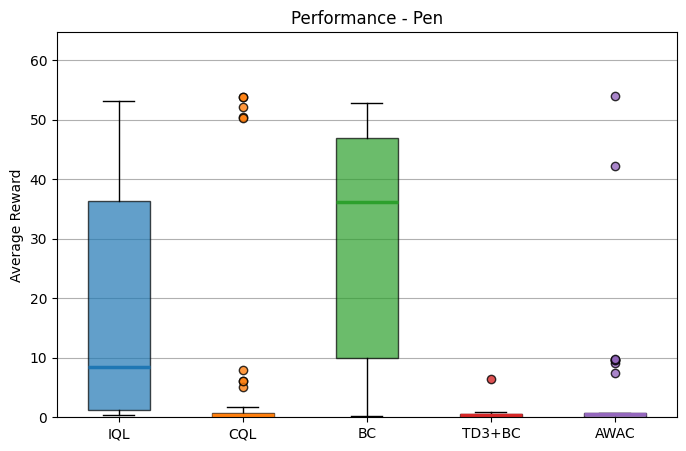

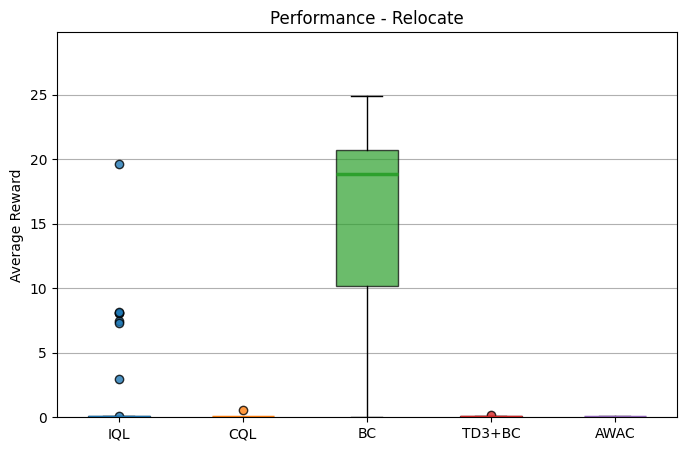

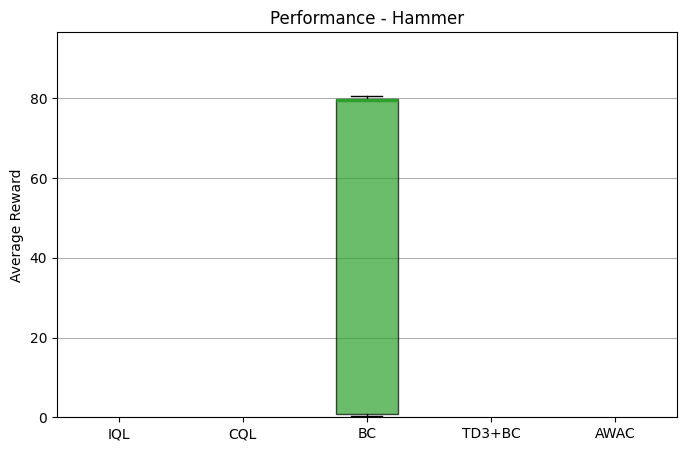

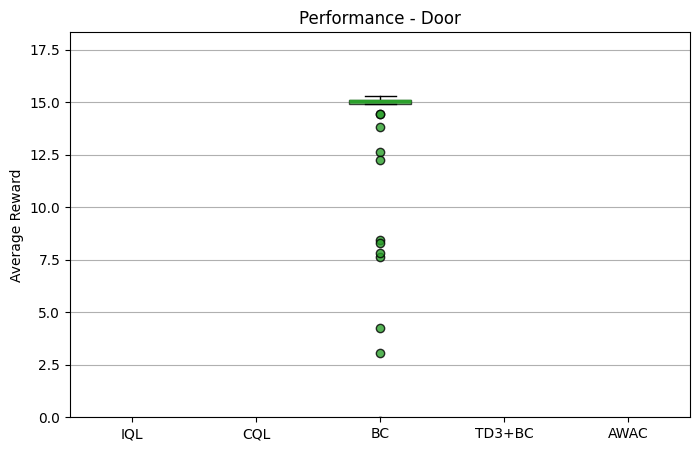

In [18]:
import matplotlib.pyplot as plt

# Dati ordinati secondo gli algoritmi
data = [
    [pen_rewards[algo] for algo in algorithms],
    [relocate_rewards[algo] for algo in algorithms],
    [hammer_rewards[algo] for algo in algorithms],
    [door_rewards[algo] for algo in algorithms]
]

tasks = ['Pen', 'Relocate', 'Hammer', 'Door']

filenames = [
    'experiment_1_1_boxplot_pen.png',
    'experiment_1_1_boxplot_relocate.png',
    'experiment_1_1_boxplot_hammer.png',
    'experiment_1_1_boxplot_door.png'
]

for t in range(4):
    fig, ax = plt.subplots(figsize=(8, 5))
    box = ax.boxplot(data[t], patch_artist=True, tick_labels=algorithms)
    
    # Colora box, mediane e outlier
    for patch, median_line, flier, algo in zip(box['boxes'], box['medians'], box['fliers'], algorithms):
        color = colors[algo]
        
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

        median_line.set_color(color)
        median_line.set_linewidth(2.5)

        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor('black')
        flier.set_alpha(0.8)
        flier.set_markersize(6)

    ax.set_title(f'Performance - {tasks[t]}')
    ax.set_ylabel('Average Reward')
    ax.grid(True, axis='y')
    ax.set_ylim(0, max(max(r) for r in data[t]) * 1.2)

    # Salva e mostra
    plt.savefig(f'../results/{filenames[t]}', dpi=300, bbox_inches='tight')
    plt.show()

## Reward Evolution

In [19]:
# Function to extract average rewards from a history
def extract_metric(history, key):
    return [entry[1][key] for entry in history]  # env contains the average reward

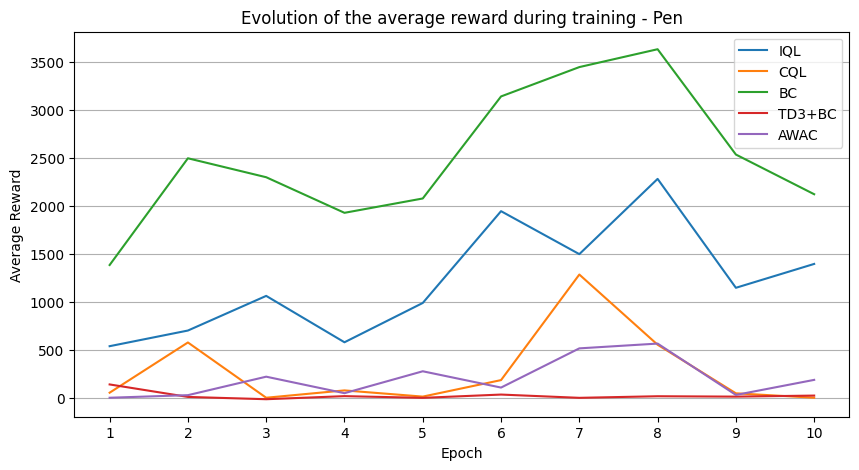

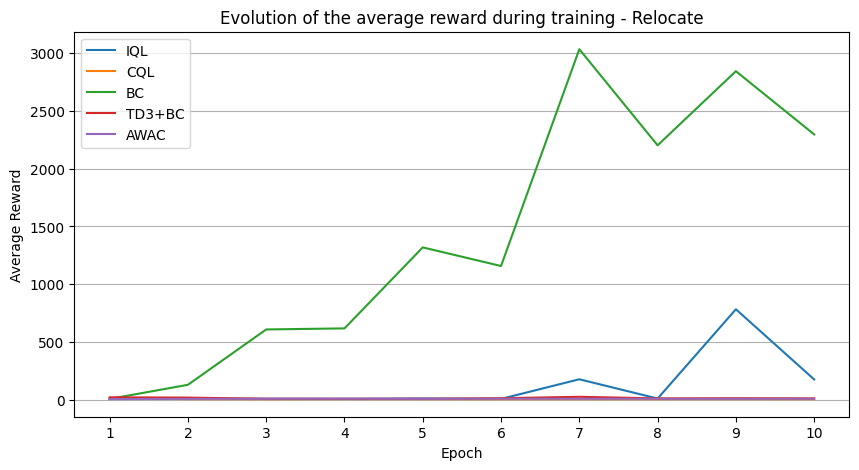

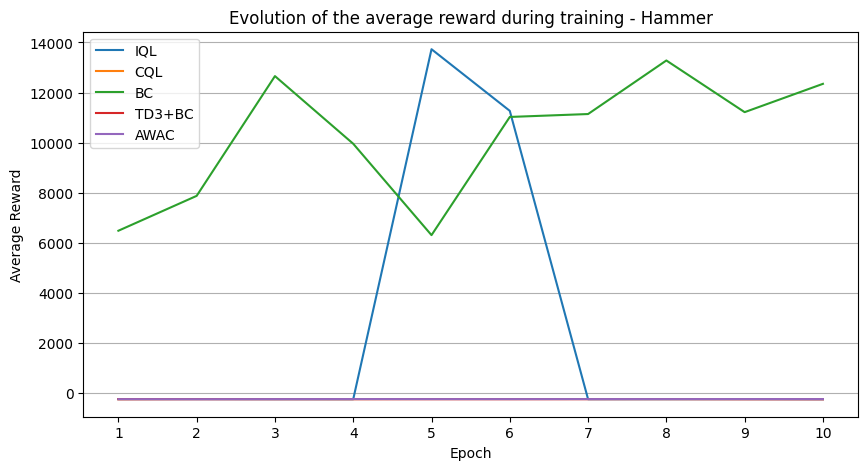

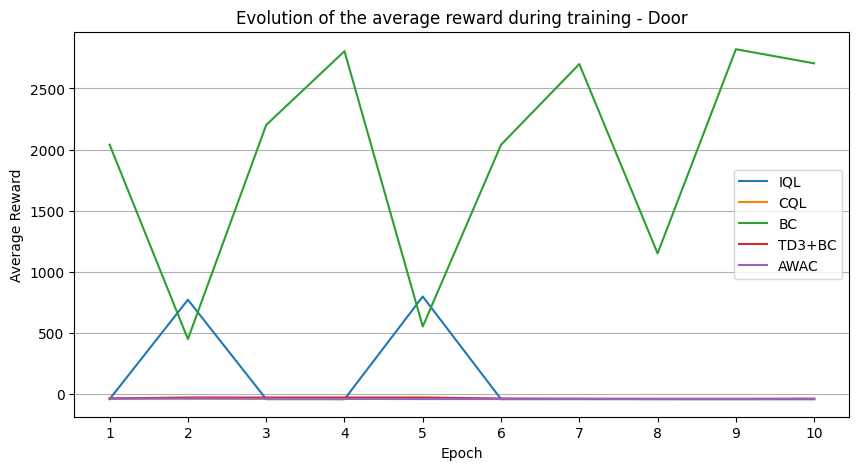

In [20]:
import matplotlib.pyplot as plt

# Liste dei dati e dei titoli
data = [pen_histories, relocate_histories, hammer_histories, door_histories]
tasks = ['Pen', 'Relocate', 'Hammer', 'Door']
filenames = [
    'experiment_1_2_reward_pen.png',
    'experiment_1_2_reward_relocate.png',
    'experiment_1_2_reward_hammer.png',
    'experiment_1_2_reward_door.png'
]

for t in range(4):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for algo in algorithms:
        rewards = extract_metric(data[t][algo], 'environment')
        ax.plot(range(1, len(rewards) + 1), rewards, label=algo, color=colors[algo])
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward')
    ax.set_title(f'Evolution of the average reward during training - {tasks[t]}')
    ax.set_xticks(range(1, len(rewards) + 1))
    ax.legend()
    ax.grid(True, axis='y')

    plt.savefig(f'../results/{filenames[t]}', dpi=300, bbox_inches='tight')
    plt.show()